<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/mountain/art1131.jpg)|![](./data/forest/cdmc317.jpg)|

The problem is realively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several differnet possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D()
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional full connected layers to our model. We removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = res.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(res.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

## Load in Data

![skimage-logo](https://scikit-image.org/_static/img/logo.png)

Check out out [`skimage`](https://scikit-image.org/) for useful functions related to processing the images. In particular checkout the documentation for `skimage.io.imread_collection` and `skimage.transform.resize`.

In [75]:
# all_images = []
# # Load in the images from mountain
# for filepath in os.listdir('./data/train/mountain'):
#     all_images.append(cv2.imread('images/{0}'.format(filepath),0))
# # Load in the images from forest
# for filepath in os.listdir('./data/train/forest'):
#     all_images.append(cv2.imread('images/{0}'.format(filepath),0))

In [76]:
# all_images_test = []
# # Load in the images from mountain
# for filepath in os.listdir('./data/validation/mountain'):
#     all_images_test.append(cv2.imread('images/{0}'.format(filepath),0))
# # Load in the images from forest
# for filepath in os.listdir('./data/validation/forest'):
#     all_images_test.append(cv2.imread('images/{0}'.format(filepath),0))

In [30]:
# # your path 
# # TRAIN data
# forest_train = 'data/train/forest/*.jpg'
# mountain_train = 'data/train/mountain/*.jpg'

# # TEST data
# forest_test = 'data/validation/forest/*.jpg'
# mountain_test = 'data/validation/mountain/*.jpg'



# # creating a collection with the available images
# # TRAIN images
# forest_train = imread_collection(forest_train).concatenate()
# mountain_train = imread_collection(mountain_train).concatenate()

# # TEST images
# forest_test = imread_collection(forest_test).concatenate()
# mountain_test = imread_collection(mountain_test).concatenate()

# # creating y labels TRAIN
# y_0 =  np.zeros(forest_train.shape[0])
# y_1 =  np.ones(mountain_train.shape[0])

# # creating y labels TEST

# y_01 =  np.zeros(forest_test.shape[0])
# y_11 =  np.ones(mountain_test.shape[0])



# X_train = np.concatenate([forest_train, mountain_train])
# X_train = resize(X_train, (520,224,224,3))
# y_train = np.concatenate([y_0, y_1])


# X_test = np.concatenate([forest_test, mountain_test])
# X_test = resize(X_test, (182,224,224,3))
# y_test = np.concatenate([y_01, y_11])


In [1]:
from skimage.io import imread_collection
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

In [2]:
# %pwd

In [2]:
# Other way of loading the data
 
# load datasets

TRAINING_DIR = './data/train'

VALIDATION_DIR = './data/validation'
 

ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

#### When using a convolutional layer as the first layer to our model, we need to reshape our data to (n_images, x_shape, y_shape, channels). All you really need to know is that you should set channels to 1 for grayscale images and set channels to 3 when you have a set of RGB-images as input.

#### The batch size must match the number of images going into our first convolutional layer.

#### Our model cannot work with categorical data directly. Ergo we must use one hot encoding. In one hot encoding, the digits 0 through 9 are represented as a set of nine zeros and a single one. The digit is determined by the location of the number 1. For example, you’d represent a 3 as [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [3]:
image_size = 224, 224
batch_size = 10 # less batch size, more features to train from
class_mode = 'binary' # categorical

#uses Resnet's preprocess input function
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
train_generator = datagen.flow_from_directory(TRAINING_DIR,
                                              batch_size=batch_size,
                                              class_mode=class_mode, # categorical
                                              target_size=image_size, # (255, 255)
                                              shuffle=True, 
                                              seed=42)
 

validation_generator = datagen.flow_from_directory(VALIDATION_DIR,
                                              batch_size=batch_size,
                                              class_mode=class_mode, # categorical
                                              target_size=image_size, # (255, 255)
                                              shuffle=True, 
                                              seed=42)

Found 520 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


## Instatiate Model

In [5]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=224,224,3)

##### The include_top parameter in ResNet50 will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes.

In [6]:
for layer in resnet.layers:
    layer.trainable = False

In [7]:
# Setup Architecture

x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

In [ ]:
# # Say not to train first layer (ResNet) model. It is already trained
# new_model.layers[0].trainable = False

In [8]:
# Compile Model
optimizer = 'adam' # SGD
loss = 'binary_crossentropy' # categorical_crossentropy


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Fit Model

In [10]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > .99999):   
            self.model.stop_training = True

In [11]:
history=model.fit(train_generator, 
          epochs=5,
          validation_data=validation_generator,
                 callbacks=[myCallback()]) # shuffle=True -> can add to fit model

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 19 steps
Epoch 1/5
52/52 [==============================] - 79s 2s/step - loss: 0.4597 - accuracy: 0.8750 - val_loss: 0.1224 - val_accuracy: 0.9560
Epoch 2/5
52/52 [==============================] - 77s 1s/step - loss: 0.0919 - accuracy: 0.9750 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 3/5
52/52 [==============================] - 74s 1s/step - loss: 0.0799 - accuracy: 0.9635 - val_loss: 0.1065 - val_accuracy: 0.9560
Epoch 4/5
52/52 [==============================] - 75s 1s/step - loss: 0.0461 - accuracy: 0.9846 - val_loss: 0.0746 - val_accuracy: 0.9615
Epoch 5/5
52/52 [==============================] - 71s 1s/step - loss: 0.0092 - accuracy: 0.9962 - val_loss: 0.1275 - val_accuracy: 0.9560


In [13]:
# Evaluate Model
validation_steps=10

test_loss, test_acc = model.evaluate(validation_generator, steps = validation_steps)

  ...
    to  
  ['...']
10/10 [==============================] - 8s 780ms/step - loss: 0.2155 - accuracy: 0.9300


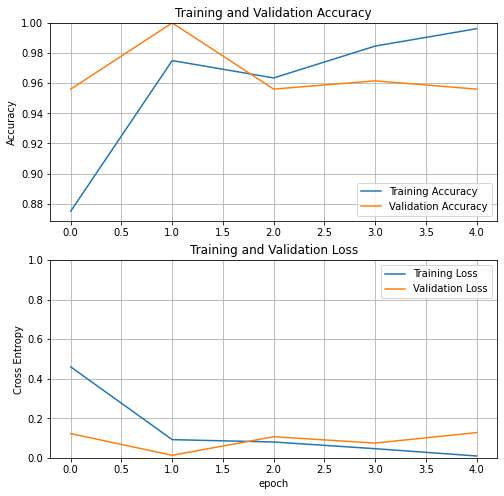

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

Train on 561 samples, validate on 141 samples
Epoch 1/5
561/561 [==============================] - 39s 69ms/sample - loss: 0.1216 - accuracy: 0.9715 - val_loss: 1.4221 - val_accuracy: 0.0000e+00
Epoch 2/5
561/561 [==============================] - 35s 62ms/sample - loss: 0.0410 - accuracy: 0.9875 - val_loss: 2.9222 - val_accuracy: 0.0000e+00
Epoch 3/5
561/561 [==============================] - 35s 62ms/sample - loss: 0.0646 - accuracy: 0.9697 - val_loss: 0.9962 - val_accuracy: 0.0000e+00
Epoch 4/5
561/561 [==============================] - 39s 70ms/sample - loss: 0.0723 - accuracy: 0.9733 - val_loss: 0.2627 - val_accuracy: 1.0000
Epoch 5/5
561/561 [==============================] - 38s 68ms/sample - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.4859 - val_accuracy: 1.0000


# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

In [18]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model # <- May Use

In [27]:
# Setup Architecture

cnn = Sequential()
cnn.add(Conv2D(1024,(3,3), activation='relu', input_shape=(224,224,3)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Conv2D(64, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Conv2D(64, (3,3), activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

# Compile Model
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print summary
cnn.fit(train_generator, 
          epochs=5, 
          validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 19 steps
Epoch 1/5
52/52 [==============================] - 602s 12s/step - loss: 26.2123 - accuracy: 0.7538 - val_loss: 1.3405 - val_accuracy: 0.8956
Epoch 2/5
52/52 [==============================] - 519s 10s/step - loss: 0.8291 - accuracy: 0.8942 - val_loss: 0.7278 - val_accuracy: 0.8846
Epoch 3/5
52/52 [==============================] - 535s 10s/step - loss: 0.2197 - accuracy: 0.9385 - val_loss: 0.4886 - val_accuracy: 0.9011
Epoch 4/5
52/52 [==============================] - 554s 11s/step - loss: 0.1099 - accuracy: 0.9577 - val_loss: 0.4841 - val_accuracy: 0.9121
Epoch 5/5
52/52 [==============================] - 543s 10s/step - loss: 0.2087 - accuracy: 0.9519 - val_loss: 0.7153 - val_accuracy: 0.8901


In [28]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 1024)    28672     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 1024)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      589888    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 215, 215, 32)      9632      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [96]:
# Compile Model


In [99]:
# Fit Model


Train on 561 samples, validate on 141 samples
Epoch 1/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.2667 - accuracy: 0.9073 - val_loss: 0.1186 - val_accuracy: 0.9858
Epoch 2/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.2046 - accuracy: 0.9073 - val_loss: 0.3342 - val_accuracy: 0.8511
Epoch 3/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.1778 - accuracy: 0.9287 - val_loss: 0.2746 - val_accuracy: 0.8723
Epoch 4/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.1681 - accuracy: 0.9323 - val_loss: 0.8487 - val_accuracy: 0.5957
Epoch 5/5
561/561 [==============================] - 18s 32ms/sample - loss: 0.1606 - accuracy: 0.9394 - val_loss: 0.3903 - val_accuracy: 0.8582


In [29]:
validation_steps=10

test_loss, test_acc = cnn.evaluate(validation_generator, steps = validation_steps)

  ...
    to  
  ['...']
10/10 [==============================] - 24s 2s/step - loss: 0.5519 - accuracy: 0.8700


In [ ]:
# predicting images
import numpy as np

from PIL import Image

img = image.load_img('/data/validation/mountain/n199031.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = net_final.predict(images, batch_size=1)
if classes ==1:
  print('Image is a mountain')
else:
  print('Image is a forest')
print(classes)

# Custom CNN Model with Image Manipulations
## *This a stretch goal, and it's relatively difficult*

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

In [ ]:
# State Code for Image Manipulation Here

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language